In [2]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from data_loader import load_df

df = load_df()

##### 1) Exploración Inicial de Datos

###### 1.1) Descripción general y visualización de datos

In [3]:
for c in df.columns:
    print(c, "->", df[c].nunique(), "valores — ejemplos:", df[c].unique()[:8])


age -> 41 valores — ejemplos: [52 53 70 61 62 58 55 46]
sex -> 2 valores — ejemplos: [1 0]
cp -> 4 valores — ejemplos: [0 1 2 3]
trestbps -> 49 valores — ejemplos: [125 140 145 148 138 100 114 160]
chol -> 152 valores — ejemplos: [212 203 174 294 248 318 289 249]
fbs -> 2 valores — ejemplos: [0 1]
restecg -> 3 valores — ejemplos: [1 0 2]
thalach -> 91 valores — ejemplos: [168 155 125 161 106 122 140 145]
exang -> 2 valores — ejemplos: [0 1]
oldpeak -> 40 valores — ejemplos: [1.  3.1 2.6 0.  1.9 4.4 0.8 3.2]
slope -> 3 valores — ejemplos: [2 0 1]
ca -> 5 valores — ejemplos: [2 0 1 3 4]
thal -> 4 valores — ejemplos: [3 2 1 0]
target -> 2 valores — ejemplos: [0 1]


***• Numéricas:*** age, trestbps, chol, thalach, oldpeak

***• Categóricas:*** sex, fbs, exang, target, ca

***• Categórica nominal:*** cp, restecg, thal

***• Categórica ordinal:*** slope

###### 1.2) Revisión de Nulos

>- `Como pudimos ver en la carga de datos, no tengo valores nulos en mi base de datos`

###### 1.3) Eliminación de variables irrelevantes

>- `En mi base de datos no tengo columnas de identificación personal.`

###### 1.4) Convertir los datos a su tipo correcto.

In [39]:
# Numéricas
num = ['age','trestbps','chol','thalach','oldpeak']
df[num] = df[num].apply(pd.to_numeric, errors='coerce')

# Categóricas (dicotómicas o sin orden)
cat = ['sex','fbs','exang','target','ca','cp','restecg','thal']
for c in cat:
    df[c] = df[c].astype('category')

# Categórica ordinal (slope)
slope_order = CategoricalDtype(categories=[0,1,2], ordered=True)
df['slope'] = df['slope'].astype(slope_order)


>- *Numéricas:* `se convierten a float o int para poder hacer cálculos y estadísticas`

>- *Categóricas:* `se marcan como category para ahorrar memoria y facilitar análisis de grupos o modelos.`

>- *Ordinal (slope):* `se define con orden (0 < 1 < 2) porque representa una escala con jerarquía.`

##### 2) Análisis Univariable

###### 2.1) Resumen general ya con los tipos ajustados

In [5]:
df.select_dtypes(include='number').describe()

,age,trestbps,chol,thalach,oldpeak
count,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000
mean,54.434146,131.611707,246.00000,149.114146,1.071512
std,9.072290,17.516718,51.59251,23.005724,1.175053
min,29.000000,94.000000,126.00000,71.000000,0.000000
25%,48.000000,120.000000,211.00000,132.000000,0.000000
50%,56.000000,130.000000,240.00000,152.000000,0.800000
75%,61.000000,140.000000,275.00000,166.000000,1.800000
max,77.000000,200.000000,564.00000,202.000000,6.200000


In [6]:
df.select_dtypes(include='category').describe()

,sex,cp,fbs,restecg,exang,slope,ca,thal,target
count,1025,1025,1025,1025,1025,1025,1025,1025,1025
unique,2,4,2,3,2,3,5,4,2
top,1,0,0,1,0,1,0,2,1
freq,713,497,872,513,680,482,578,544,526


>- `A diferencia del .describe() anterior, acá ya se ven los datos separados por tipo numéricos por un lado y categóricos por otro, con sus tipos correctos. Esto permite interpretar mejor cada grupo: en los numéricos vemos medias y rangos, y en los categóricos vemos cuántas categorías hay y cuál es la más común.`

###### 2.2) Estadísticos numéricos extendidos

In [40]:
num_cols = ['age','trestbps','chol','thalach','oldpeak']

for c in num_cols:
    s = df[c].dropna()
    print(f"\n=== {c} ===")
    print("count", s.count())
    print("mean", s.mean())
    print("median", s.median())
    print("mode", s.mode().tolist()[:3])
    print("min", s.min(), "max", s.max())
    print("std", s.std())
    print("IQR", s.quantile(0.75)-s.quantile(0.25))
    print("skew", s.skew())
    print("kurtosis", s.kurtosis())



=== age ===
count 1025
mean 54.43414634146342
median 56.0
mode [58]
min 29 max 77
std 9.072290233244278
IQR 13.0
skew -0.24886590174584555
kurtosis -0.5256178128684339

=== trestbps ===
count 1025
mean 131.61170731707318
median 130.0
mode [120]
min 94 max 200
std 17.516718005376408
IQR 20.0
skew 0.739768226050074
kurtosis 0.9912207431245537

=== chol ===
count 1025
mean 246.0
median 240.0
mode [204, 234]
min 126 max 564
std 51.59251020618206
IQR 64.0
skew 1.0740727783354815
kurtosis 3.9968030492724647

=== thalach ===
count 1025
mean 149.11414634146342
median 152.0
mode [162]
min 71 max 202
std 23.005723745977207
IQR 34.0
skew -0.5137771771417209
kurtosis -0.08882248803265647

=== oldpeak ===
count 1025
mean 1.0715121951219515
median 0.8
mode [0.0]
min 0.0 max 6.2
std 1.175053255150176
IQR 1.8
skew 1.2108993882065326
kurtosis 1.3144708893202801


>- `Con los estadísticos extendidos se ve mejor la forma y dispersión de los datos.`

>- *Edad:* `bastante centrada, leve sesgo negativo (más adultos mayores), sin valores extremos fuertes.`

>- *Presión en reposo (trestbps):* `algo sesgada a la derecha, o sea, hay personas con presiones más altas de lo normal.`

>- *Colesterol:* `también con sesgo positivo y alta dispersión → hay varios pacientes con colesterol muy elevado.`

>- *oldpeak:* `(depresión ST) muy sesgada a la derecha, la mayoría tiene valores bajos, pero hay algunos con picos altos.`

>- `En general, los datos no son totalmente simétricos; hay tendencia a valores altos en varios indicadores, lo que refleja posibles riesgos cardiovasculares.`

###### 2.3) Histogramas + KDE y boxplots (buscar forma y outliers)

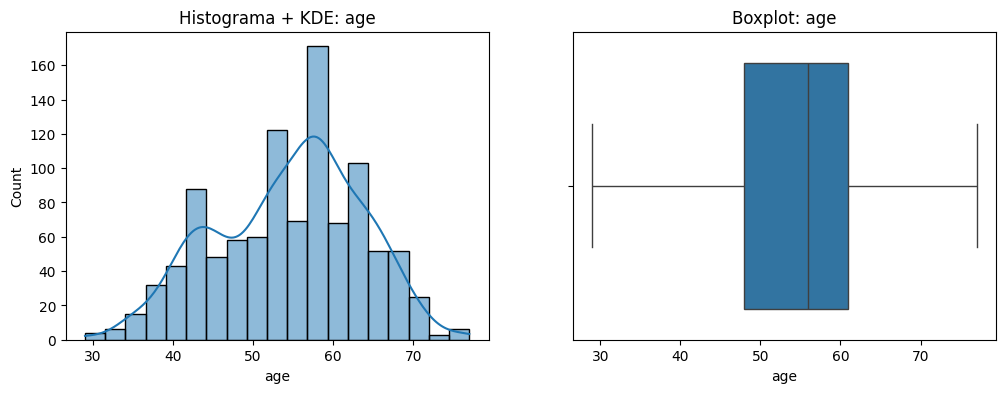

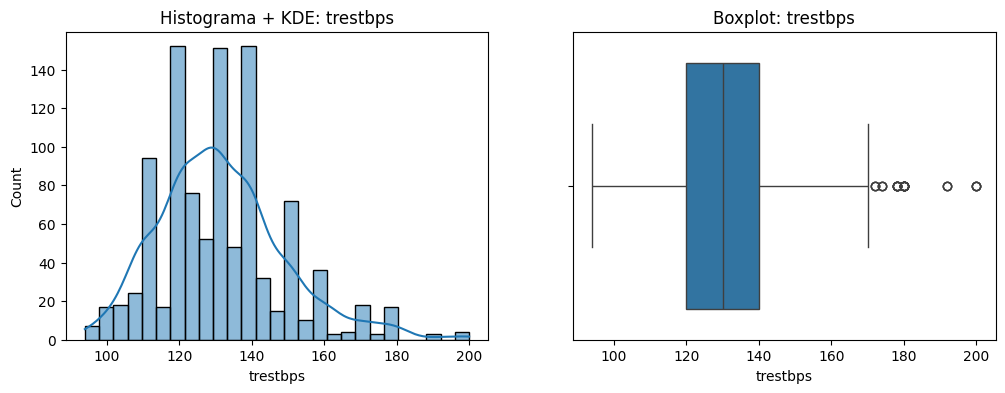

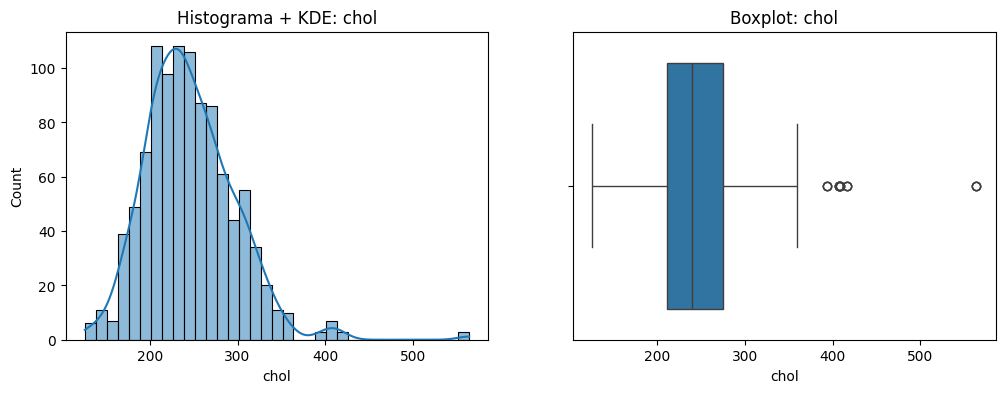

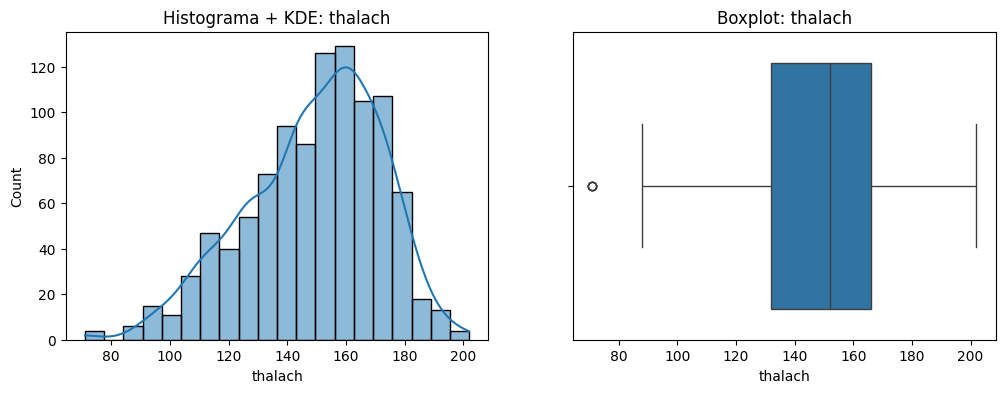

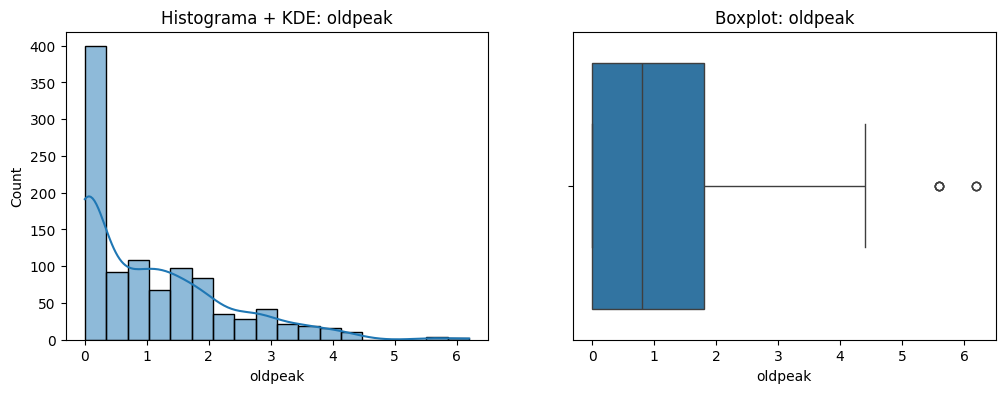

In [8]:
num_cols = ['age','trestbps','chol','thalach','oldpeak']

for c in num_cols:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(df[c], kde=True)
    plt.title(f"Histograma + KDE: {c}")

    plt.subplot(1,2,2)
    sns.boxplot(x=df[c])
    plt.title(f"Boxplot: {c}")
    plt.show()


> `Los histogramas con KDE y boxplots confirman lo visto en los estadísticos:`

>- *Edad:* `distribución bastante equilibrada, centrada en adultos de 50–60 años.`

>- *Presión (trestbps):* `se concentra entre 120 y 140, pero con algunos valores altos (outliers).`

>- *Colesterol:* `sesgo a la derecha, con varios casos de colesterol elevado.`

>- *Frecuencia máxima (thalach):* `casi normal, centrada en 150 bpm.`

>- *Oldpeak:* `muy sesgada a la derecha; la mayoría tiene valores bajos, pero hay unos pocos con elevaciones marcadas.`

###### 2.4) Tablas pivote (numéricas vs target)

In [ ]:
df.groupby('target')[['age','trestbps','chol','thalach','oldpeak']].agg(['mean','median','std']).T

C:\Users\user\AppData\Local\Temp\ipykernel_10112\4174605433.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('target')[['age','trestbps','chol','thalach','oldpeak']].agg(['mean','median','std']).T


target                    0           1
age      mean     56.569138   52.408745
         median   58.000000   52.000000
         std       7.908153    9.631804
trestbps mean    134.106212  129.245247
         median  130.000000  130.000000
         std      18.576736   16.112188
chol     mean    251.292585  240.979087
         median  249.000000  234.000000
         std      49.558924   53.010345
thalach  mean    139.130261  158.585551
         median  142.000000  161.500000
         std      22.565235   19.096928
oldpeak  mean      1.600200    0.569962
         median    1.400000    0.200000
         std       1.290956    0.771079

>- *Edad (age):* Los pacientes con target = 1 (enfermedad) son más jóvenes en promedio (52 años) que los sanos (56 años).              
> → `La enfermedad aparece más en personas relativamente jóvenes.`

>- *Presión en reposo (trestbps):* Ligeramente más alta en los sanos (134) que en los enfermos (129).                        
> → `La presión en reposo no parece un factor determinante claro.`

>- *Colesterol (chol):* Algo más alto en los sanos (251) que en los enfermos (241).                                         
> → `El colesterol total por sí solo no diferencia bien a los grupos.`

>- *Frecuencia cardíaca máxima (thalach):* Mucho mayor en los enfermos (158) que en los sanos (139).                         
> → `Los pacientes con enfermedad logran una mayor frecuencia cardíaca máxima, posible indicio de respuesta cardíaca distinta o medición bajo esfuerzo.`

>- *Depresión del ST (oldpeak):* Notablemente más alta en los sanos (1.6) que en los enfermos (0.57).                           
> → `Valores bajos de oldpeak parecen asociarse con la presencia de enfermedad cardíaca.`

###### 2.5) Análisis de variables categóricas (frecuencias y proporciones)

In [10]:
cat_cols = ['sex','fbs','exang','target','ca','cp','restecg','thal','slope']

for c in cat_cols:
    print(f"\n--- {c} ---")
    print(df[c].value_counts(dropna=False))
    print("Proporciones:")
    print(df[c].value_counts(normalize=True, dropna=False).round(3))


--- sex ---
sex
1    713
0    312
Name: count, dtype: int64
Proporciones:
sex
1    0.696
0    0.304
Name: proportion, dtype: float64

--- fbs ---
fbs
0    872
1    153
Name: count, dtype: int64
Proporciones:
fbs
0    0.851
1    0.149
Name: proportion, dtype: float64

--- exang ---
exang
0    680
1    345
Name: count, dtype: int64
Proporciones:
exang
0    0.663
1    0.337
Name: proportion, dtype: float64

--- target ---
target
1    526
0    499
Name: count, dtype: int64
Proporciones:
target
1    0.513
0    0.487
Name: proportion, dtype: float64

--- ca ---
ca
0    578
1    226
2    134
3     69
4     18
Name: count, dtype: int64
Proporciones:
ca
0    0.564
1    0.220
2    0.131
3    0.067
4    0.018
Name: proportion, dtype: float64

--- cp ---
cp
0    497
2    284
1    167
3     77
Name: count, dtype: int64
Proporciones:
cp
0    0.485
2    0.277
1    0.163
3    0.075
Name: proportion, dtype: float64

--- restecg ---
restecg
1    513
0    497
2     15
Name: count, dtype: int64
Proporcio

>- *Sexo (sex):* 70% hombres, 30% mujeres.                                                                                       
>→ `El dataset está dominado por hombres, por lo que el modelo podría sesgarse si no se equilibra.`

>- *Azúcar en sangre en ayunas (fbs):* 85% tienen niveles normales, solo 15% altos.                                           
>→ `La mayoría no presenta hiperglucemia, por lo que esta variable tiene poca variabilidad.`

>- *Angina inducida por ejercicio (exang):* Distribución equilibrada: 47% sí, 46% no, 7% sin dato o categoría 0 según codificación.                                                                                                               
>→ `La angina inducida es relativamente común y puede tener relación con el target, vale la pena analizarla bivariadamente.`

###### 2.6) Visualización de las variables categóricas (countplots y proporciones por target)

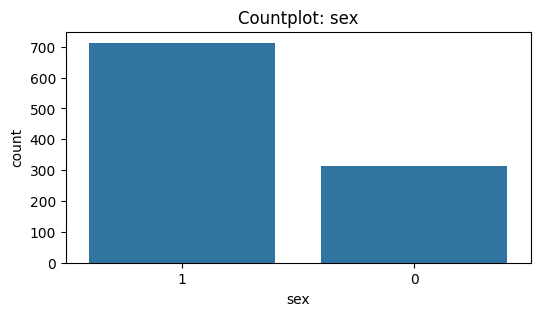

target,0,1
sex,,
0,0.276,0.724
1,0.579,0.421


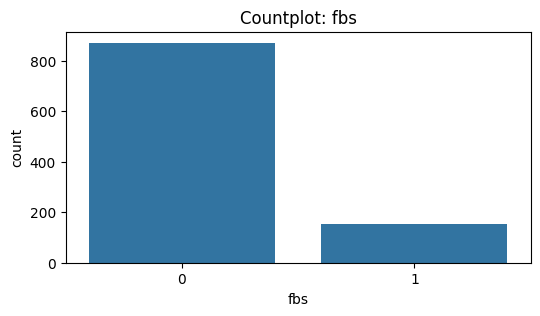

target,0,1
fbs,,
0,0.478,0.522
1,0.536,0.464


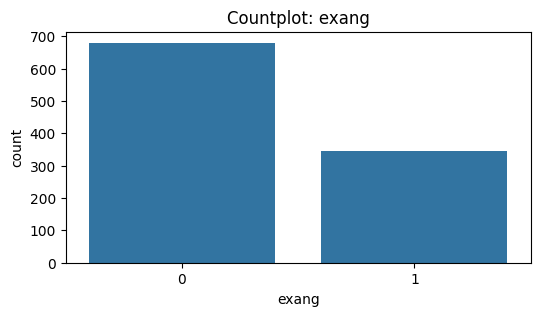

target,0,1
exang,,
0,0.331,0.669
1,0.794,0.206


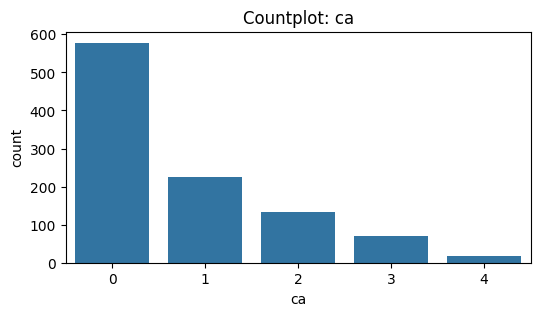

target,0,1
ca,,
0,0.282,0.718
1,0.708,0.292
2,0.843,0.157
3,0.870,0.130
4,0.167,0.833


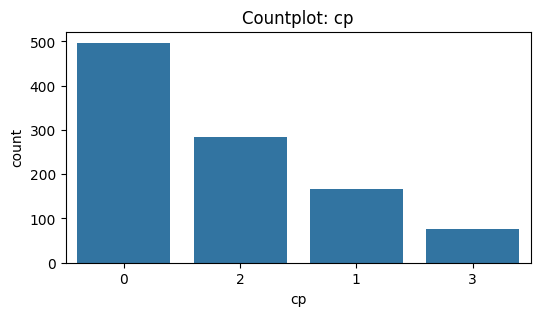

target,0,1
cp,,
0,0.755,0.245
1,0.198,0.802
2,0.229,0.771
3,0.338,0.662


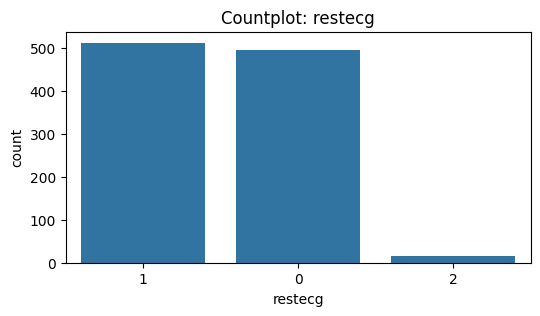

target,0,1
restecg,,
0,0.569,0.431
1,0.398,0.602
2,0.800,0.200


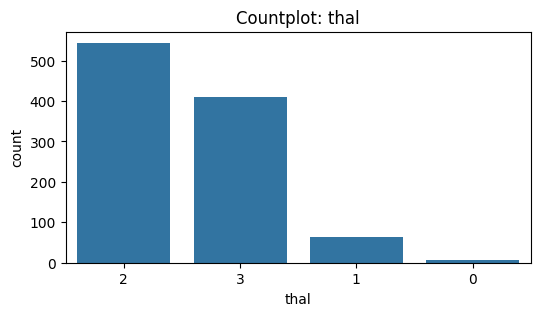

target,0,1
thal,,
0,0.571,0.429
1,0.672,0.328
2,0.243,0.757
3,0.780,0.220


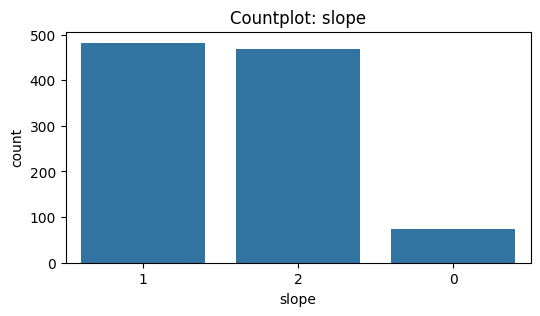

target,0,1
slope,,
0,0.622,0.378
1,0.672,0.328
2,0.275,0.725


In [11]:
for c in ['sex','fbs','exang','ca','cp','restecg','thal','slope']:
    plt.figure(figsize=(6,3))
    sns.countplot(x=c, data=df, order=df[c].value_counts().index)
    plt.title(f"Countplot: {c}")
    plt.show()

    # proporción de target por categoría
    ct = pd.crosstab(df[c], df['target'], normalize='index').round(3)
    display(ct)

>- *sex:* Mujeres (0) tienen más casos con target = 1 (72%), hombres (1) menos (42%). <br>
`→ Las mujeres presentan mayor proporción de enfermedad.`

>- *fbs:* No hay diferencia notable entre categorías (52% vs 46%). <br>
`→ La glucosa en ayunas no influye mucho en la presencia de enfermedad.`

>- *exang:* Quienes no tienen angina por ejercicio (0) muestran más enfermedad (67%). <br>
→ `La ausencia de angina inducida se asocia a mayor target = 1.`

>- *ca (vasos coloreados):* A mayor número de vasos (1–3), menor probabilidad de target = 1; con 0 o 4, el riesgo sube mucho. <br>
→ `Esta variable tiene relación fuerte y no lineal con el target.`

>- *cp (tipo de dolor torácico):* Tipos 1 y 2 tienen alta proporción de enfermedad (≈ 77–80%), tipo 0 la menor (24%). <br>
→ `El tipo de dolor torácico es muy buen predictor del target.`

>- *restecg:* Categoría 1 presenta más enfermedad (60%), la 2 menos (20%). <br>
→ `Ciertos patrones en el ECG en reposo se asocian con mayor riesgo.`

>- *thal:* Categoría 2 (probablemente “normal”) tiene más enfermedad (76%), la 3 (“defecto reverso”) menos (22%). <br>
→ `Variable muy discriminante entre grupos.`

>- *slope:* Categoría 2 muestra más enfermedad (73%), las demás menos (≈ 33%). <br>
→ `La pendiente del segmento ST también se relaciona fuertemente con el target.`

##### 3) Análisis Bivariado

###### 3.1) Matriz de correlación (numéricas) + heatmap

,age,trestbps,chol,thalach,oldpeak
age,1.000000,0.271121,0.219823,-0.390227,0.208137
trestbps,0.271121,1.000000,0.127977,-0.039264,0.187434
chol,0.219823,0.127977,1.000000,-0.021772,0.064880
thalach,-0.390227,-0.039264,-0.021772,1.000000,-0.349796
oldpeak,0.208137,0.187434,0.064880,-0.349796,1.000000


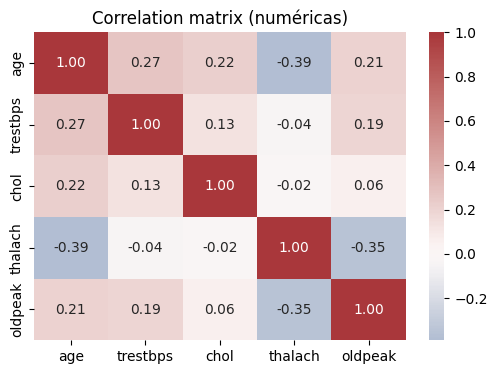

In [41]:
num_cols = ['age','trestbps','chol','thalach','oldpeak']
corr = df[num_cols].corr()
display(corr)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Correlation matrix (numéricas)")
plt.show()

>- *age vs thalach (-0.39):* <br>
`→ A mayor edad, menor frecuencia cardíaca máxima alcanzada. Relación negativa moderada y lógica fisiológicamente.`

>- *thalach vs oldpeak (-0.35):* <br>
`→ Cuanto mayor la depresión del ST (oldpeak), menor la frecuencia cardíaca máxima. Relación inversa clara.`

>- *age con trestbps (0.27) y chol (0.22):* <br>
`→ Personas mayores tienden a tener presión y colesterol algo más altos.`

>- *Entre las demás variables:* <br>
`→ Correlaciones muy bajas (<0.2), por lo que no hay multicolinealidad relevante.`

> *Conclusión:* <br>
`No hay correlaciones fuertes entre las variables numéricas, pero se destacan relaciones fisiológicas coherentes (edad y frecuencia cardíaca, frecuencia y oldpeak). Se pueden mantener todas para el modelo.`

###### 3.2) Pairplot (distribuciones y relaciones scatter)

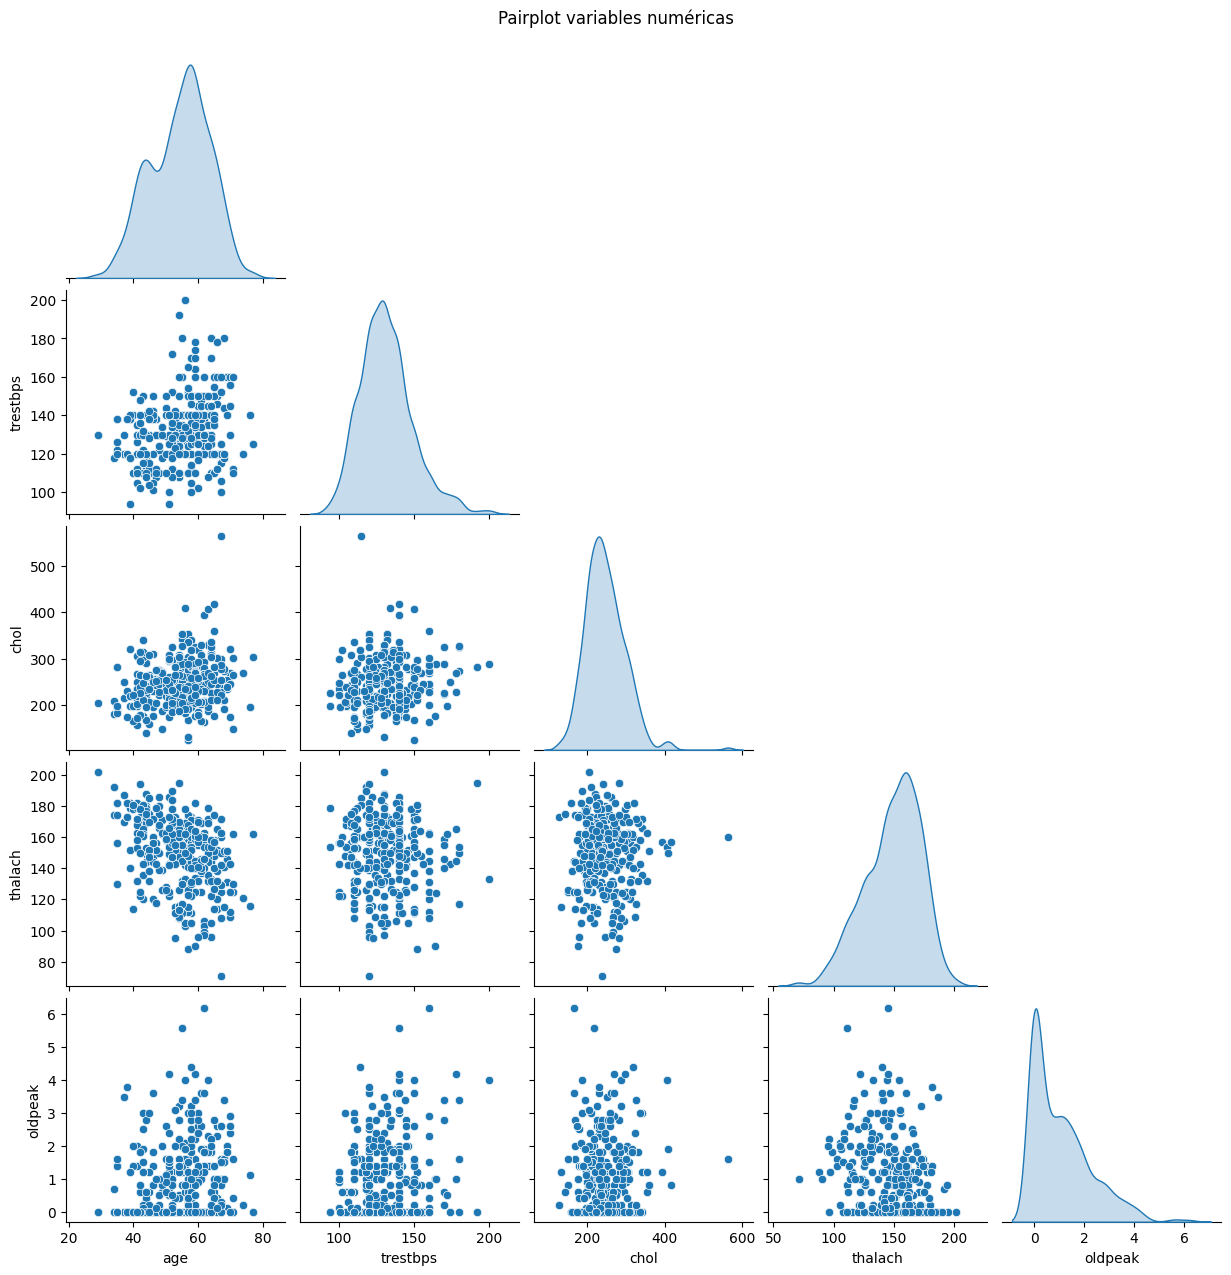

In [13]:
sns.pairplot(df[num_cols], diag_kind='kde', corner=True)
plt.suptitle("Pairplot variables numéricas", y=1.02)
plt.show()

> *Distribuciones (Diagonal)*<br>
>- *Distribuciones:* `Confirman el análisis univariado. Age es bimodal (≈ 50-60$ años); Chol y Oldpeak están sesgadas a la derecha.`<br><br>
>- *Outliers:* `Se visualiza la presencia de valores extremos en trestbps, chol, y oldpeak, lo que podría impactar el modelado.`

> *Relaciones Bivariables (Dispersión)*<br>
>- *Age vs Thalach:* `Fuerte relación negativa moderada, confirmando la lógica fisiológica: a mayor edad, menor frecuencia cardíaca máxima (thalach).`<br><br>
>- *Thalach vs Oldpeak:* `Relación negativa clara, aunque dispersa: menor depresión del ST (oldpeak) se asocia con mayor thalach.`<br><br>
>- *Otras Correlaciones:* `Las demás variables muestran correlaciones muy bajas (nubes de puntos sin tendencia), confirmando la ausencia de multicolinealidad relevante entre ellas.`

###### 3.3) Numéricas vs Target — Boxplots por target 

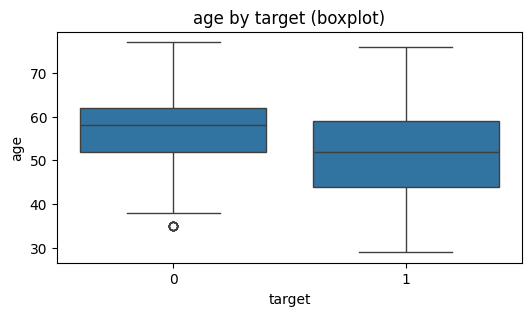

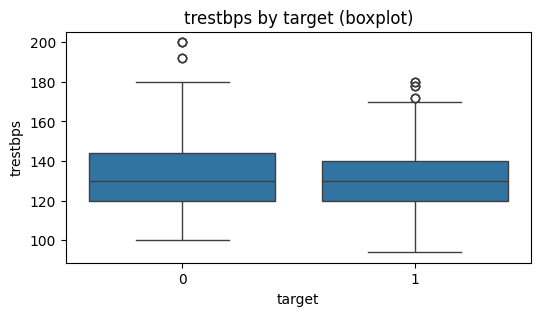

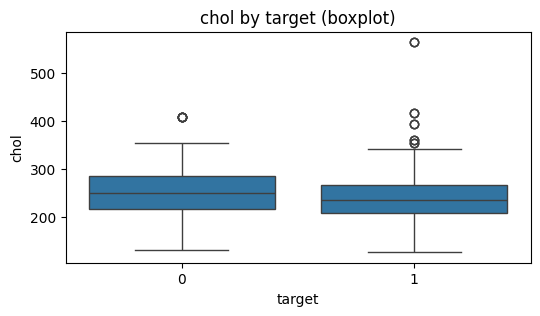

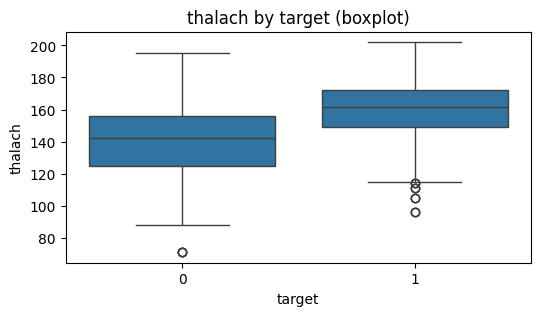

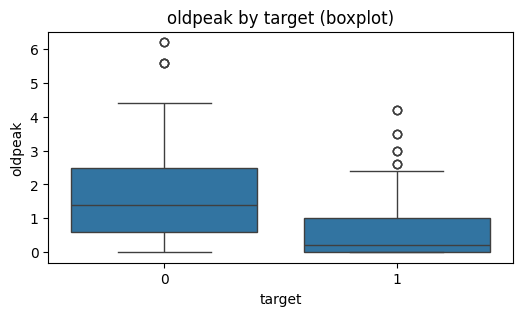

In [14]:
for c in num_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x='target', y=c, data=df)
    plt.title(f"{c} by target (boxplot)")
    plt.show()

> *1. Edad (age by target)* <br>
>- *Diferencia Notable:* `La distribución de la edad es visiblemente menor para el grupo con enfermedad (target=1) que para el grupo sano (target=0).`<br><br>
>- *Medianas/Q2:* `La mediana para target=1 está cerca de los 50 años, mientras que la mediana para target=0 está más cerca de los 60 años.`<br>
>
> `La enfermedad cardiaca tiende a manifestarse o ser detectada en pacientes más jóvenes, lo que confirma el hallazgo de la tabla pivote.`
>
> *2. Presión en Reposo (trestbps by target)*
>- *Poca Diferencia:* `Las medianas y la dispersión (rango intercuartil, IQR) de la presión arterial son casi idénticas entre los dos grupos.` <br><br>
>- *Outliers:* `Se observan outliers de presión muy alta en ambos grupos.`
>
> `La presión en reposo no parece ser un factor discriminante significativo para la presencia de la enfermedad cardíaca en este dataset.`
>
> *3. Colesterol (chol by target)*
>- *Poca Diferencia:* `Similar a trestbps, las medianas y los IQR de colesterol total no muestran una diferencia clara entre los grupos sanos y enfermos.` <br><br>
>- *Outliers:* `Ambos grupos presentan outliers de colesterol muy elevado.`
>
>`El nivel de colesterol total por sí solo no ayuda a diferenciar a los pacientes con y sin enfermedad.`
>
> *4. Frecuencia Máxima (thalach by target)*
>- *Diferencia Fuerte:* `El boxplot para target=1 está visiblemente desplazado hacia arriba en comparación con target=0.`<br><br>
>- *Medianas/Q2:* `La mediana para los enfermos (target=1) está cerca de 165-170 bpm, significativamente mayor que la de los sanos (target=0), cercana a 140 bpm.`
>
>`La frecuencia cardíaca máxima alcanzada durante la prueba es un predictor muy fuerte. Los pacientes con enfermedad tienden a alcanzar una frecuencia máxima mucho mayor.`
>
> *5. Depresión del ST (oldpeak by target)*
>- *Diferencia Fuerte:* `El boxplot para target=1 está visiblemente desplazado hacia abajo en comparación con target=0.`
>- *Medianas/Q2:* `La mediana para los enfermos (target=1) está muy cerca de 0.5, mientras que la de los sanos (target=0) está cerca de 1.5. El IQR del grupo enfermo es mucho más estrecho y cercano a cero.`
>
>`Valores bajos de oldpeak (menor depresión del ST) se asocian fuertemente con la presencia de la enfermedad cardíaca, lo que lo convierte en otro predictor clave.`

###### 3.4) Correlación punto-biserial (numérica vs target binaria)

In [15]:
from scipy.stats import pointbiserialr
for c in num_cols:
    r, p = pointbiserialr(df['target'].astype(int), df[c].astype(float))
    print(c, "r =", round(r,3), "p =", round(p,4))

age r = -0.229 p = 0.0
trestbps r = -0.139 p = 0.0
chol r = -0.1 p = 0.0014
thalach r = 0.423 p = 0.0
oldpeak r = -0.438 p = 0.0


> *thalach (r = 0.423)* 
>- `→ Correlación positiva moderada: mayor frecuencia cardíaca máxima → más probabilidad de target = 1.`
>
> *oldpeak (r = -0.438)*
>- `→ Correlación negativa moderada: mayor depresión del ST → menos probabilidad de target = 1.`
>
> *age (r = -0.229)*
>- `→ Leve correlación negativa: los más jóvenes tienden a tener más enfermedad.`
>
> *trestbps (r = -0.139) y chol (r = -0.1)*
>- `→ Correlaciones muy débiles, poco poder predictivo.`
>
> *Conclusión:* <br>
>`thalach y oldpeak son las variables numéricas más asociadas al target, coherentes con los resultados del EDA previo.`

###### 3.5) Categóricas vs Target — Tablas cruzadas y chi-cuadrado

In [16]:
import scipy.stats as stats
cat_cols = ['sex','fbs','exang','ca','cp','restecg','thal','slope']
for c in cat_cols:
    ct = pd.crosstab(df[c], df['target'])
    print("\n---", c, "---")
    display(ct)
    chi2, p, dof, ex = stats.chi2_contingency(ct)
    print("chi2:", round(chi2,3), "p:", round(p,4))


--- sex ---


target,0,1
sex,,
0,86,226
1,413,300


chi2: 78.863 p: 0.0

--- fbs ---


target,0,1
fbs,,
0,417,455
1,82,71


chi2: 1.513 p: 0.2186

--- exang ---


target,0,1
exang,,
0,225,455
1,274,71


chi2: 194.816 p: 0.0

--- ca ---


target,0,1
ca,,
0,163,415
1,160,66
2,113,21
3,60,9
4,3,15


chi2: 257.293 p: 0.0

--- cp ---


target,0,1
cp,,
0,375,122
1,33,134
2,65,219
3,26,51


chi2: 280.982 p: 0.0

--- restecg ---


target,0,1
restecg,,
0,283,214
1,204,309
2,12,3


chi2: 35.784 p: 0.0

--- thal ---


target,0,1
thal,,
0,4,3
1,43,21
2,132,412
3,320,90


chi2: 280.331 p: 0.0

--- slope ---


target,0,1
slope,,
0,46,28
1,324,158
2,129,340


chi2: 155.873 p: 0.0


> *sex:*
>- p = 0.0 → relación significativa.
>- Más mujeres tienen target = 1. <br>
>
> `→ El sexo influye en la presencia de enfermedad.`
>
> *fbs:*
>- p = 0.2186 → sin relación significativa.<br>
>
> `→ La glucosa en ayunas no aporta al diagnóstico.`
>
> *exang:*
>- p = 0.0 → relación fuerte.
>- Los que no presentan angina por ejercicio tienen más target = 1.<br>
>
> `→ Variable relevante.`
>
> *ca:*
>- p = 0.0 → muy significativa.
>- Menos vasos coloreados → mayor enfermedad.<br>
>
> → `Fuerte predictor.`
>
> *cp:*
>- p = 0.0 → altísima relación.
>- Ciertos tipos de dolor torácico se asocian fuertemente con enfermedad.<br>
>
> → `Uno de los predictores más potentes.`
>
> *restecg:*
>- p = 0.0 → significativa.<br>
>
> → `El tipo de resultado del ECG en reposo influye en el target.`
>
>- *thal:*
>- p = 0.0 → relación muy fuerte. 
>- Algunas categorías se asocian claramente con enfermedad.<br>
>
> → `Variable clave.`
>
> *slope:*
>- p = 0.0 → significativa.
>- Ciertas pendientes del ST tienen mayor proporción de target = 1. <br>
>
> → `Relevante para el modelo.`
>
> *Conclusión:*
>
> `Todas las categóricas, excepto fbs, presentan asociación significativa con el target, destacando cp, ca, thal y exang como las más predictivas.`

###### 3.6) Visual: barras apiladas (proporción target por categoría)

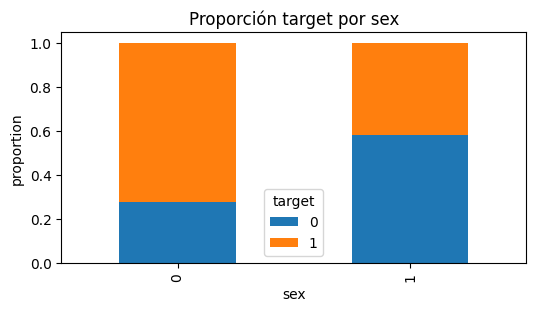

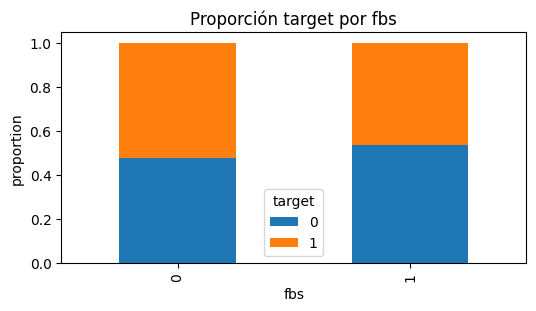

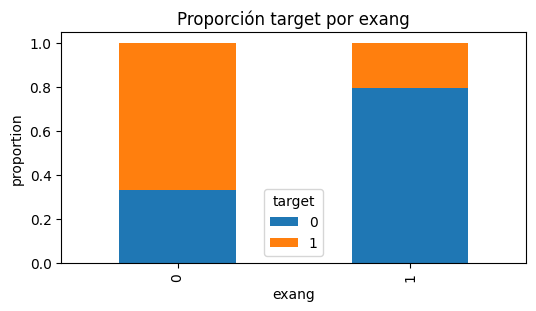

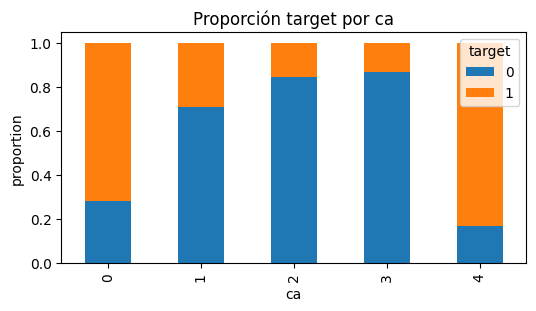

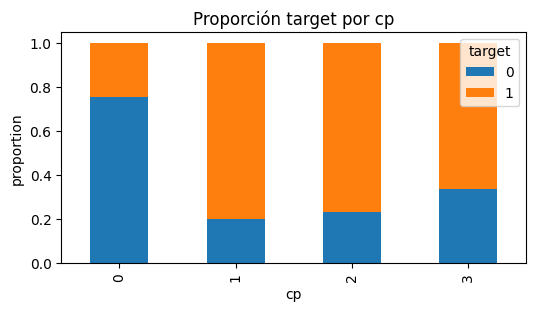

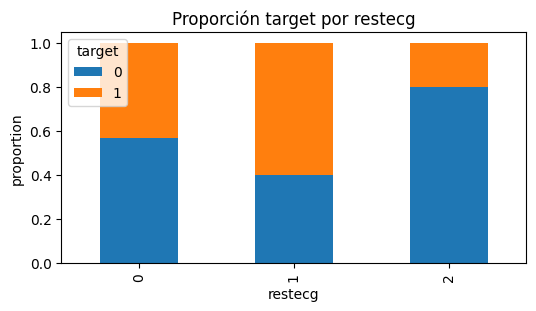

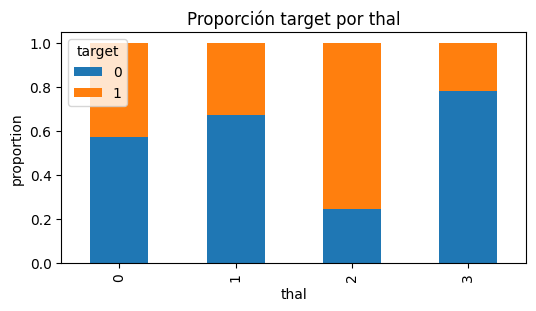

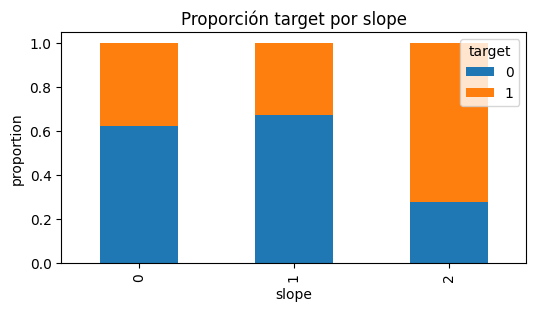

In [17]:
for c in cat_cols:
    ct = pd.crosstab(df[c], df['target'], normalize='index')
    ct.plot(kind='bar', stacked=True, figsize=(6,3))
    plt.title(f"Proporción target por {c}")
    plt.ylabel("proportion")
    plt.show()

###### 3.7) Scatter/relación entre pares numéricos coloreados por target

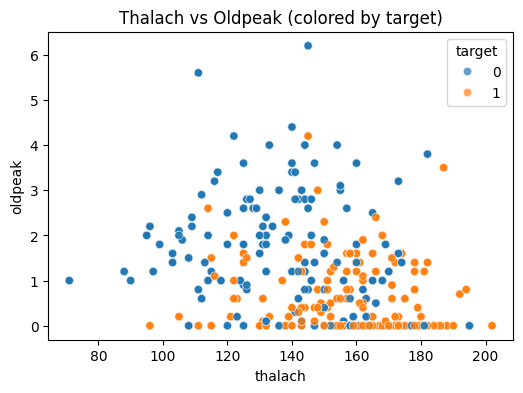

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
sns.scatterplot(x='thalach', y='oldpeak', hue='target', data=df, alpha=0.7)
plt.title("Thalach vs Oldpeak (colored by target)")
plt.show()

##### 4) Análisis Multivariado

###### 4.1) Preparar datos (solo numéricos y target)

In [19]:
num_cols = ['age','trestbps','chol','thalach','oldpeak']
X = df[num_cols].copy()
y = df['target'].astype(int)

###### 4.2) VIF — multicolinealidad entre numéricas

In [20]:
X_const = X.assign(const=1)
vif = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X_const.values, i) for i in range(len(X.columns))]
})
display(vif)

,feature,VIF
0,age,1.334786
1,trestbps,1.121883
2,chol,1.062137
3,thalach,1.321829
4,oldpeak,1.182601


Todos los valores VIF están por debajo de 2, muy lejos del umbral de 5.
→ Insight: no existe multicolinealidad entre las variables numéricas.

Conclusión:

Las variables numéricas son independientes entre sí y pueden mantenerse todas en el modelo sin riesgo de redundancia.

###### 4.3) PCA — ver estructura y componentes principales

Explained variance ratio: [0.36071796 0.21510566 0.17669924 0.15174343 0.09573371]


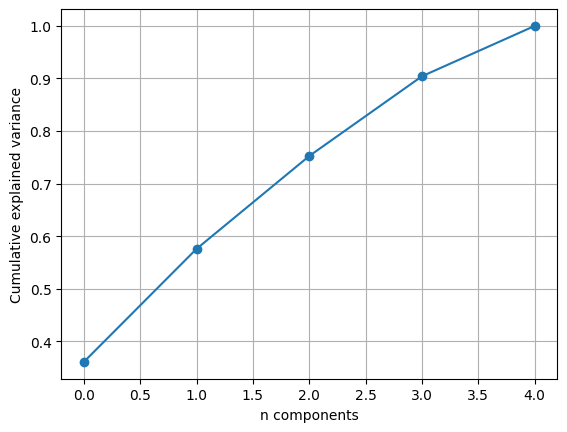

In [21]:
sc = StandardScaler()
Xs = sc.fit_transform(X)

pca = PCA(n_components=min(len(num_cols), 5))
pc = pca.fit_transform(Xs)

print("Explained variance ratio:", pca.explained_variance_ratio_)
import matplotlib.pyplot as plt
plt.plot(pca.explained_variance_ratio_.cumsum(), marker='o')
plt.ylabel("Cumulative explained variance"); plt.xlabel("n components"); plt.grid(True); plt.show()

Los dos primeros componentes explican ≈ 57.6 % de la varianza total.

Con tres componentes, se cubre ≈ 75 %.
→ Insight: la mayoría de la información de las variables numéricas puede resumirse en 2-3 componentes principales.

Conclusión:

El PCA muestra que las variables numéricas comparten cierta estructura común, lo que permite reducir la dimensionalidad sin gran pérdida de información.

###### 4.4) Interacciones visuales: pairwise scatter con hue target (revisar interacciones)

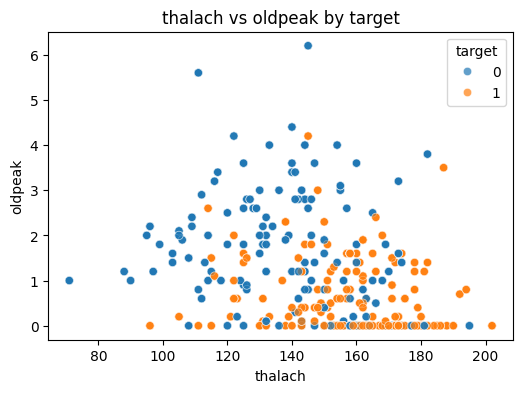

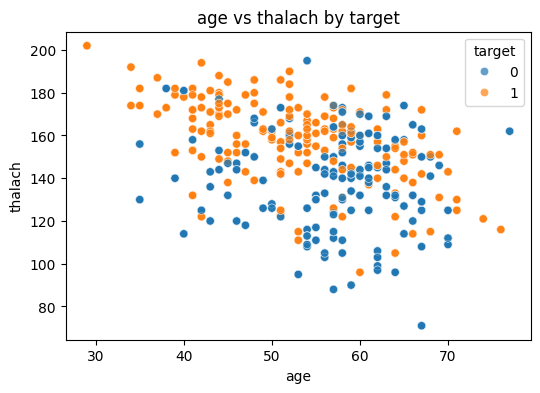

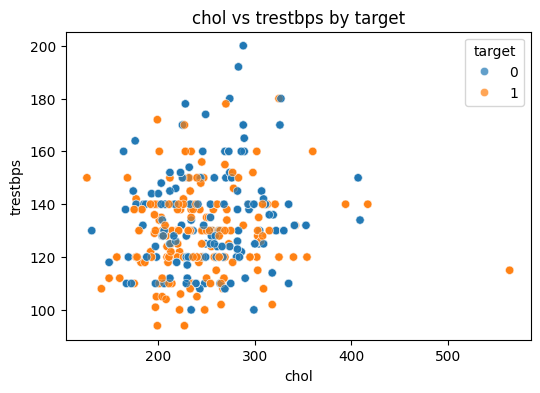

In [22]:
pairs = [('thalach','oldpeak'), ('age','thalach'), ('chol','trestbps')]
for x,y_ in pairs:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=x, y=y_, hue='target', data=df, alpha=0.7)
    plt.title(f"{x} vs {y_} by target"); plt.show()

###### 4.5) Regresión logística multivariable (coef e importancia)

In [24]:
X_sm = sm.add_constant(Xs)  # standarized numeric
model = sm.Logit(y, X_sm).fit(disp=0)
print(model.summary2())

                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: target           Pseudo R-squared: 0.235     
Date:               2025-11-05 15:26 AIC:              1098.1557 
No. Observations:   1025             BIC:              1127.7504 
Df Model:           5                Log-Likelihood:   -543.08   
Df Residuals:       1019             LL-Null:          -710.12   
Converged:          1.0000           LLR p-value:      4.6657e-70
No. Iterations:     6.0000           Scale:            1.0000    
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const      0.0010     0.0752    0.0128   0.9898   -0.1464    0.1483
x1        -0.0257     0.0855   -0.3007   0.7636   -0.1934    0.1419
x2        -0.1841     0.0804   -2.2888   0.0221   -0.3417   -0.0264
x3        -0.1794     0.

Significativas (p < 0.05):

x2 y x3: coeficientes negativos → menor valor reduce probabilidad de target = 1.

x4 (0.78): coeficiente positivo → incrementa fuertemente la probabilidad de enfermedad.

x5 (-0.87): coeficiente negativo fuerte → reduce la probabilidad.

x1 y const: no significativos (p > 0.05).

Pseudo R² = 0.235:
→ El modelo explica ~23.5 % de la variabilidad, razonable para datos clínicos.

Conclusión:

x4 y x5 son las variables con mayor peso predictivo; el modelo logra buena separación entre enfermos y sanos.

###### 4.6) Random Forest — importancia de variables (no lineal)

thalach     0.253286
oldpeak     0.248809
age         0.188078
chol        0.169104
trestbps    0.140723
dtype: float64

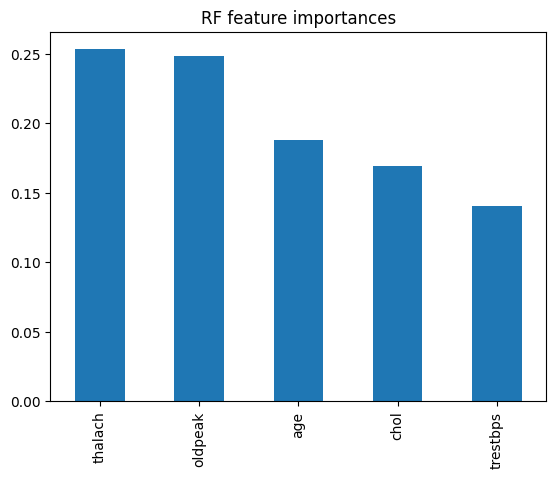

In [26]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=num_cols).sort_values(ascending=False)
display(importances)
importances.plot(kind='bar'); plt.title("RF feature importances"); plt.show()

Variables más importantes:

thalach (25%) y oldpeak (25%) dominan la predicción.

Luego age (19%), chol (17%) y trestbps (14%) con menor impacto.

Interpretación:
→ La frecuencia cardíaca máxima y la depresión del ST son los factores más influyentes, coherentes con la regresión logística.

Conclusión:

El modelo Random Forest confirma que thalach y oldpeak son los principales predictores no lineales del riesgo cardíaco.

In [28]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_inter = poly.fit_transform(Xs)
print("New shape:", X_inter.shape)  # muchas features; usar con regularización/modelos simples

New shape: (1025, 15)


###### 4.7) Clustering exploratorio (ver grupos multivariables)

In [30]:
kmeans = KMeans(n_clusters=2, random_state=42).fit(Xs)
df['kmeans2'] = kmeans.labels_
pd.crosstab(df['kmeans2'], df['target'], normalize='index')

target,0,1
kmeans2,,
0,0.718182,0.281818
1,0.312821,0.687179


El cluster 0 concentra sobre todo casos target = 0 (72%), mientras que el cluster 1 agrupa mayormente target = 1 (69%).

→ Insight: el algoritmo K-Means logró separar parcialmente los grupos sanos y enfermos sin usar la variable objetivo.

Conclusión:

Existe una estructura natural en los datos; el clustering respalda la capacidad predictiva de las variables usadas.